<a href="https://colab.research.google.com/github/herbgruutz/langgraph/blob/notebooks/Introduction_to_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to LangGraph

In this tutorial, we will build a support chatbot in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.



## Setup

First, install the required packages:

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith
%pip install -U langchain-groq
%pip install -U tavily-python
%pip install langchain-community langchainhub

Next, set your API keys:

In [2]:
# @title Set Environment
project_name = "Introduction To Langgraph" # @param {type:"string"}
api_keys = "anthropic_api_key"
import getpass
import os
from google.colab import userdata

def is_colab():
    """Detect if the code is running in Google Colab"""
    try:
        from google.colab import drive
        return True
    except ImportError:
        return False

def set_env(var: str, api_keys: list):
    """Set environment variables for API keys"""
    for key in api_keys:
        if not os.environ.get(key.upper()):
            if is_colab():
                os.environ[key.upper()] = userdata.get(key)
            else:
                os.environ[key.upper()] = getpass.getpass(f"{key.upper()}: ")

api_keys = [
    "tavily_api_key",
    "langchain_api_key",
    "groq_api_key",
    # "anthropic_api_key"
]

for key in api_keys:
    set_env(key, api_keys)

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = project_name

## Part 1: Build a Basic Chatbot



### Define `StateGraph`

A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**Notice** that we've defined our `State` as a TypedDict with a single key: `messages`. The `messages` key is annotated with the [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.


### Define `chatbot` Node

Nodes represent units of work. They are typically regular python functions.

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns an updated `messages` list. This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.


### Finish Graph

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [5]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [6]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [7]:
graph = graph_builder.compile()

### Visualize Graph

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

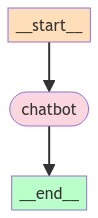

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Run Graph

Now let's run the chatbot!

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: Wrte jupyter code snippet that when run in a notebook will do something interesting with javascript
Assistant: Sure! Here is a code snippet that uses the `IPython.display` module to display a JavaScript alert message in a Jupyter notebook:

```
from IPython.display import Javascript

Javascript("alert('Hello, Jupyter!')")
```

When you run this code in a Jupyter notebook, it will display an alert message with the text "Hello, Jupyter!".

Here is another example that uses the `display` function from the `IPython.display` module to display a JavaScript countdown timer:

```
from IPython.display import display, Javascript

def countdown(t):
    """Display a countdown timer for the given number of seconds."""
    display(Javascript("""
        function countdown(t) {
            var seconds = t;
            var timer = setInterval(function() {
                minutes = parseInt(seconds/60, 10)
                seconds = seconds % 60;
                minutes = minutes < 10 ? "0" + minu

### Snippet

In [19]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

from langchain_groq import ChatGroq


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768")



def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

## Part 2: Add Tool to Chatbot


In [20]:
from langchain import hub
from langchain.agents import create_openai_tools_agent
from langchain_community.tools.tavily_search import TavilySearchResults, TavilyAnswer
from langchain.agents import AgentExecutor


### Define Tool

In [12]:
# The following code raise an error.
chat = ChatGroq(
    temperature=0,
    groq_api_key=os.environ["GROQ_API_KEY"],
    model_name="mixtral-8x7b-32768",
)


prompt = hub.pull("hwchase17/openai-tools-agent")
tool = TavilySearchResults(max_results=2)
tools = [tool]
agent = create_openai_tools_agent(chat, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, stream_runnable = False)
agent_executor.invoke({"input": "What is Langchain?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'Langchain'}`


[{'url': 'https://github.com/langchain-ai/langchain', 'content': 'About\n⚡ Building applications with LLMs through composability ⚡\nResources\nLicense\nCode of conduct\nSecurity policy\nStars\nWatchers\nForks\nReleases\n291\nPackages\n0\nUsed by 39k\nContributors\n1,848\nLanguages\nFooter\nFooter navigation Latest commit\nGit stats\nFiles\nREADME.md\n🦜️🔗 LangChain\n⚡ Building applications with LLMs through composability ⚡\nLooking for the JS/TS library? ⚡ Building applications with LLMs through composability ⚡\nLicense\nlangchain-ai/langchain\nName already in use\nUse Git or checkout with SVN using the web URL.\n 📖 Documentation\nPlease see here for full documentation, which includes:\n💁 Contributing\nAs an open-source project in a rapidly developing field, we are extremely open to contributions, whether it be in the form of a new feature, improved infrastructure, or better d

{'input': 'What is Langchain?',
 'output': 'Based on the information provided by the tool, Langchain is an open-source project launched in October 2022 by Harrison Chase while working at a machine learning startup called Robust Intelligence. It was later incorporated in April 2023 and raised over $20 million in funding from Sequoia Capital and Benchmark. Langchain can read from more than 50 document types and data sources, and it has integrations with various systems, including Amazon, Google, and Microsoft Azure cloud storage, API wrappers for news, movie information, and weather, and Bash for summarization, syntax and semantics checking, and execution of shell scripts, among others. It is a language model integration framework, and its use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.'}

In [54]:
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-tools-agent', 'lc_hub_commit_hash': 'c18672812789a3b9697656dd539edf0120285dcae36396d0b548ae42a4ed66f5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')), MessagesPlacehold

### Define Graph

We have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [13]:
graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

### Define `BasicToolNode`

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [14]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

### Define `conditional_edges`

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `action` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear.

In [15]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end."""
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'action' if it calls a tool, or end the loop if it responds directly.

The prebuilt `tools_condition` returns the "`__end__`" string if no tool calls are made. When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution. Because the condition can return `__end__`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!


### Visualize Graph

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

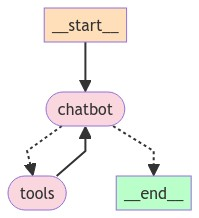

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Run Graph




In [45]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: how much data throughput does the ethereum blockchain do ?
Assistant: The Ethereum blockchain can process a theoretical maximum of around 15 transactions per second, but in practice, it is often much less than that due to network congestion and other factors. In terms of data throughput, this translates to a few hundred kilobytes of data per block, with each block being added to the blockchain approximately every 15 seconds. However, it's important to note that the actual data throughput can vary widely depending on the state of the network and the complexity of the transactions being processed.
User: what is a good blockchain to use if you want to record json strings and interact with web apis?
Assistant: 
Assistant: [{"url": "https://www.zeeve.io/blog/indexed-blockchain-data-vs-json-rpc-apis-for-web3-applications/", "content": "JSON RPC APIs and indexed blockchain data are the two widely preferred and feasible options for retrieving blockchain data in a transparent, secure, and

### Add 2markdown Node



In [52]:
# configure the api
import getpass
markdown_api_key = getpass.getpass("2Markdown api_key")


2Markdown api_key··········


In [53]:
from langchain_community.document_loaders import ToMarkdownLoader

url = "https://www.moesif.com/blog/api-product-management/api-analytics/Top-8-Blockchain-APIs-For-Developers/"

loader = ToMarkdownLoader(url=url, api_key=markdown_api_key)
docs = loader.load()
print(docs[0].page_content)


Developers are always looking for new ways to make their applications more secure and efficient. Blockchain APIs are one way to do this. A blockchain API is an application programming interface that allows developers to interact with a blockchain. By using a blockchain API, developers can access the data and functionality of a blockchain without having to build their own blockchain platform. This can save time and resources, as well as provide a more secure environment for development. In this post, we will explore the best blockchain APIs for developers. We will look at the features and benefits of each blockchain API, as well as how they can be used to create more secure and efficient decentralized applications.

## What Is Blockchain?

A blockchain is a digital ledger of all cryptocurrency transactions. It is constantly growing as “completed” blocks are added to it with a new set of recordings. Each block contains a cryptographic hash of the previous block, a timestamp, and transact

### Snippet

- replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode), and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

In [44]:
from typing import Annotated, Union
from typing_extensions import TypedDict

from langchain_groq import ChatGroq

from langchain import hub
from langchain.agents import create_openai_tools_agent
from langchain_community.tools.tavily_search import TavilySearchResults, TavilyAnswer
from langchain.agents import AgentExecutor

from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

## Part 3: Add Memory to Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.



### Create `SqliteSaver` checkpointer

In [55]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

**Notice** that we've specified `:memory` as the Sqlite DB path. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to connect to your own DB and/or use one of the other checkpointer classes.



### Define Graph

Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [ ]:
from typing import Annotated, Union

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

### Compile Graph with checkpointer

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

### Visualize Graph

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

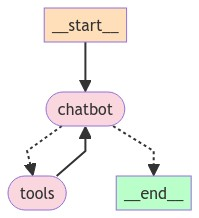

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Configure Chatbot

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [58]:
config = {"configurable": {"thread_id": "1"}}

### Run Graph

In [59]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I help you today? I can use tools to find information or answer questions to the best of my ability. If I don't need to use a tool, I'll go ahead and provide a direct response. Let's get started!


**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [60]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, of course! You mentioned that your name is Will. I'm here to help you with any questions or information you need. If I don't know the answer, I'll do my best to find the information using the tools at my disposal. Is there something specific you'd like to know?


**Notice** that we are't the memory using an external list: it's all handled by the checkpointer! You can inspect the full execution in this [LangSmith trace](https://smith.langchain.com/public/48387889-c002-47a8-9f6a-1f6b298db64b/r) to see what's going on.

Don't believe me? Try this using a different config.

In [29]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, I remember that your name is not mentioned in the instructions. How can I assist you today? If you have a question that requires the use of a tool, I will make sure to follow the tool instructions. If not, I will respond directly without using a tool, as specified in the text instructions.


**Notice** that the **only** change we've made is to modify the `thread_id` in the config. See this call's [LangSmith trace](https://smith.langchain.com/public/4647adf6-3835-4ce3-ba39-26ed4f167411/r) for comparison.


### Inspect Graph State

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [37]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='4a1dc45c-6e70-49e0-8489-a7ad4a3d46fd'), AIMessage(content="Hello Will! How can I help you today? I can use tools to find information or answer questions to the best of my ability. If I don't need to use a tool, I'll go ahead and provide a direct response. Let's get started!", response_metadata={'finish_reason': 'stop', 'logprobs': None, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'token_usage': {'completion_time': 0.097678048, 'completion_tokens': 55, 'prompt_time': 0.500506386, 'prompt_tokens': 1215, 'queue_time': None, 'total_time': 0.598184434, 'total_tokens': 1270}}, id='run-908cef1c-d21c-425c-88ce-1b1f0477c807-0'), HumanMessage(content='Remember my name?', id='d48766cc-832d-477d-a663-17a7ae65676d'), AIMessage(content="Yes, of course! You mentioned that your name is Will. I'm here to help you with any questions or information you need. If I don't know the answer,

In [38]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `__end__` state, so `next` is empty.

LangGraph's checkpointing even handles **arbitrary complex graph states**, which is much more expressive and powerful than simple chat memory.
  
### Snippet

In [57]:
from typing import Annotated, Union

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

memory = SqliteSaver.from_conn_string(":memory:")

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(temperature=0.1, model_name="mixtral-8x7b-32768")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

First, start from the snippet for Part 2

### compile with `interrupt_before`

In [ ]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

### Run

In [62]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_rx7p)
 Call ID: call_rx7p
  Args:
    query: LangGraph


### Inspect


In [63]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**Notice** that unlike last time, the "next" node is set to **'action'**. We've interrupted here! Let's check the tool invocation.

In [64]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_rx7p'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.



### Resume Graph by passing `None`
Next, continue the graph! Passing in ==`None`== will just let the graph continue where it left off, without adding anything new to the state.

In [43]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://python.langchain.com/v0.1/docs/langgraph/", "content": "\ud83e\udd9c\ud83d\udd78\ufe0fLangGraph. \u26a1 Building language agents as graphs \u26a1. Overview . LangGraph is a library for building stateful, multi-actor applications with LLMs. Inspired by Pregel and Apache Beam, LangGraph lets you coordinate and checkpoint multiple chains (or actors) across cyclic computational steps using regular python functions (or JS).The public interface draws inspiration from NetworkX."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is framework agnostic (each node is a regular python function). It extends the core Runnable API (shared interface for streaming, async, and batch calls) to make it easy to: Seamless state management across multiple turns of conversation or tool usage. The ability to flexibly route between nodes based on dynamic

### Inspect

Review this call's [LangSmith trace](https://smith.langchain.com/public/6a9012c0-bfa2-4fba-8dce-961d233f9512/r) to see the exact work that was done in the above call. Notice that the ==state== is loaded in the first step so that your chatbot can continue where it left off.

**Congrats!** You've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential ==UIs== you can create with your AI systems. Since we have already added a **checkpointer**, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.



### Snippet

In [61]:
from typing import Annotated, Union

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

memory = SqliteSaver.from_conn_string(":memory:")

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(temperature=0.1, model_name="mixtral-8x7b-32768")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

## Part 5: Update State


Thankfully, LangGraph lets you **manually update state**! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.


Begin with previous graph snippet.

In [ ]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

So far, all of this is an _exact repeat_ of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.



### Mimic Tool Node with `update_state`

 with `ToolMessage` and `AIMessage`

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

Now the graph is complete, since we've provided the final response message! Since state updates simulate a graph step, they even generate corresponding traces. Inspec the [LangSmith trace](https://smith.langchain.com/public/c45207bb-bd26-4c9a-b631-928bbeebfbcb/r) of the `update_state` call above to see what's going on.

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [ ]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

### Inspect

Check out the [LangSmith trace](https://smith.langchain.com/public/ce83989f-6e49-4bdd-bcd5-f54ca55c8d00/r/30b1406a-ae5b-4e9e-9fe5-032be6efb92e) for this update call at the provided link. **Notice** from the trace that the graph continues into the `tools_condition` edge. We just told the graph to treat the update `as_node="chatbot"`. If we follow the diagram below and start from the `chatbot` node, we naturally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls.

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

**Notice**: that we've continued to add AI messages to the state. Since we are acting as the `chatbot` and responding with an AIMessage that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

### Overwrite `messages`

The [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function we used to annotate our graph's `State` above controls how updates are made to the `messages` key. This function looks at any message IDs in the new `messages` list. If the ID matches a message in the existing state, [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) overwrites the existing message with the new content.

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

### update the tool invocation

 for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [ ]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

**Notice** that we've modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".

Check out the [LangSmith trace](https://smith.langchain.com/public/cd7c09a6-758d-41d4-8de1-64ab838b2338/r) to see the state update call - you can see our new message has successfully updated the previous AI message.

### Resume graph

 by streaming with an input of `None` and the existing config.

In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

### Inspect

Check out the [trace](https://smith.langchain.com/public/2d633326-14ad-4248-a391-2757d01851c4/r/6464f2f2-edb4-4ef3-8f48-ee4e249f2ad0) to see the tool call and later LLM response. **Notice** that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the _modified_ state.

In [ ]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

**Congratulations!** You've used `interrupt_before` and `update_state` to manually modify the state as a part of a human-in-the-loop workflow. Interruptions and state modifications let you control how the agent behaves. Combined with persistent checkpointing, it means you can `pause` an action and `resume` at any point. Your user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...])` (or `interrupt_after`) if you want to explicitly pause the graph whenever it reaches a node. Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.

## Part 6: Customize State

if you want to define complex behavior you can add additional fields to the state.

In the examples above, we involved a human deterministically: the graph __always__ interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.



### Define graph
 with an updated `State`

In [ ]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

### Define `RequestAssistance` Schema

Next, define a schema to show the model to let it decide to request assistance.

In [ ]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

### Define Nodes
The primary modification here is flip the `ask_human` flag if we see that the chat bot has invoked the `RequestAssistance` flag.

In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

Next, create the "human" `node`. This `node` function is mostly a placeholder in our graph that will trigger an interrupt. If the human does __not__ manually update the state during the `interrupt`, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

### Define Edges then Compile

Next, define the conditional logic. The `select_next_node` will route to the `human` node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

Recall that the `tools_condition` function simply checks to see if the `chatbot` has responded with any `tool_calls` in its response message. If so, it routes to the `action` node. Otherwise, it ends the graph.

In [ ]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

Finally, add the simple directed edges and compile the graph. These edges instruct the graph to **always** flow from node `a`->`b` whenever `a` finishes executing.

In [ ]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

### Visualize
If you have the visualization dependencies installed, you can see the graph structure below:

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

The chat bot can either request help from a human (chatbot->select->human), invoke the search engine tool (chatbot->select->action), or directly respond (chatbot->select->__end__). Once an action or request has been made, the graph will transition back to the `chatbot` node to continue operations.

### Run Graph
Let's see this graph in action. We will request for expert assistance to illustrate our graph.

In [ ]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

### Inspect

**Notice:** the LLM has invoked the "`RequestAssistance`" tool we provided it, and the interrupt has been set. Let's inspect the graph state to confirm.

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

The graph state is indeed **interrupted** before the `'human'` node. We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

Next, respond to the chatbot's request by:
1. Creating a `ToolMessage` with our response. This will be passed back to the `chatbot`.
2. Calling `update_state` to manually update the graph state.

In [ ]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

You can inspect the state to confirm our response was added.

In [ ]:
graph.get_state(config).values["messages"]

### Resume Graph
Next, **resume** the graph by invoking it with `None` as the inputs.

In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

### Inspect

**Notice** that the chat bot has incorporated the updated state in its final response. Since **everything** was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

**Congratulations!** you've now added an additional node to your assistant graph to let the chat bot decide for itself whether or not it needs to interrupt execution. You did so by updating the graph `State` with a new `ask_human` field and modifying the interruption logic when compiling the graph. This lets you dynamically include a human in the loop while maintaining full **memory** every time you execute the graph.



### Snippet

In [ ]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

## Part 7: Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality.

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.




### Use Previous Graph

### Run
Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [ ]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

### Replay

Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [ ]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

### Inspect

**Notice** that checkpoints are saved for every step of the graph. This _spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [ ]:
print(to_replay.next)
print(to_replay.config)

**Notice** that the checkpoint's config (`to_replay.config`) contains a `thread_ts` **timestamp**. Providing this `thread_ts` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

### Resume

In [ ]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

Notice that the graph resumed execution from the `**action**` node. You can tell this is the case since the first value printed above is the response from our search engine tool.

**Congratulations!** You've now used time-travel checkpoint traversal in LangGraph. Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive applications.

## Conclusion

Congrats! You've completed the intro tutorial and built a chat bot in LangGraph that supports tool calling, persistent memory, human-in-the-loop interactivity, and even time-travel!

The [LangGraph documentation](https://langchain-ai.github.io/langgraph/) is a great resource for diving deeper into the library's capabilities.